# Weighted metric

In [5]:
from typing import Iterable, List

import numpy as np
import pandas as pd


def weighted_metric(mal_acc: List[float], benign_acc: float) -> float:
    """
    benign_acc: accuracy of benign class
    mal_acc: list of `s` accuracies
    0.5 * benign_acc + 0.5 * (1/(1+2+...+s)) * (s*mal_acc_1 + (s-1)*mal_acc_2 + ... + 1*mal_acc_s)
    """
    s = len(mal_acc)
    if s == 0:
        mal_weighted_avg = 1.0
    
    else:
        weights = list(range(s, 0, -1))
        mal_weighted_avg = np.average(mal_acc, weights=weights)

    weighted_avg = np.average([benign_acc, mal_weighted_avg])

    return weighted_avg

def unweighted_metric(mal_acc: List[float], benign_acc: float) -> float:
    if len(mal_acc) == 0:
        mal_avg = 1.0
    else:
        mal_avg = np.average(mal_acc)
    unweighted_avg = np.average([benign_acc, mal_avg])

    return unweighted_avg

def calc_metrics(df, centroid=True, nn=True, weighted=True, unweighted=True):
    if len(df[df['lsb']==0]) == 0:
        benign_acc_centroid = 1
        benign_acc_nn = 1
    else:
        if centroid:
            benign_acc_centroid = df[df['lsb']==0]['test_acc_centroid'].iloc[0]
        if nn:
            benign_acc_nn = df[df['lsb']==0]['test_acc_nn'].iloc[0]

    df_mal = df[~(df['lsb'] == 0)].sort_values(by='lsb', ascending=True)

    metrics_dict = {}

    if centroid:
        mal_acc_centroid = df_mal['test_acc_centroid'].tolist()
        if unweighted:
            unweighted_metric_centroid = unweighted_metric(mal_acc_centroid, benign_acc_centroid)
            metrics_dict['unweighted_metric_centroid'] = unweighted_metric_centroid

        if weighted:
            weighted_metric_centroid = weighted_metric(mal_acc_centroid, benign_acc_centroid)
            metrics_dict['weighted_metric_centroid'] = weighted_metric_centroid
    if nn:
        mal_acc_nn = df_mal['test_acc_nn'].tolist()
        if unweighted:
            unweighted_metric_nn = unweighted_metric(mal_acc_nn, benign_acc_nn)
            metrics_dict['unweighted_metric_nn'] = unweighted_metric_nn

        if weighted:
            weighted_metric_nn = weighted_metric(mal_acc_nn, benign_acc_nn)
            metrics_dict['weighted_metric_nn'] = weighted_metric_nn

    return pd.Series(metrics_dict)

In [5]:
from typing import Literal
import pandas as pd

from model_xray.configs.enums import *

from model_xray.utils.script_utils import get_siamese_results_dataframe

mc_name:Literal['famous_le_10m', 'famous_le_100m']="famous_le_10m"
imtype:ImageType=ImageType.GRAYSCALE_FOURPART
imsize:int=100
mode:Literal['st', 'es', 'ub', 'none']='ub'

model_arch: Literal['osl_siamese_cnn', 'srnet'] = 'osl_siamese_cnn'
embed_payload_type: PayloadType = PayloadType.BINARY_FILE


df = get_siamese_results_dataframe(
    mc_name=mc_name,
    imtype=imtype,
    imsize=imsize,
    mode=mode,
    model_arch=model_arch,
    embed_payload_type=embed_payload_type
)

df.head()

,run num,mc,lsb,test_acc_centroid,test_acc_nn,model_lsb
0,0,famous_le_10m,0,1.0,0.4,1
1,0,famous_le_10m,1,0.0,0.8,1
2,0,famous_le_10m,2,0.0,0.6,1
3,0,famous_le_10m,3,0.0,0.2,1
4,0,famous_le_10m,4,0.4,0.2,1


In [20]:
df = df[(df['model_lsb'] == df['lsb']) | (df['lsb'] == 0)]

In [11]:
df['mc'] = df['mc'].replace(
    {
        'maleficnet_benigns': 'maleficnet',
        'maleficnet_mals': 'maleficnet'
    }
)

In [3]:
df['mc'].value_counts()

mc
famous_le_10m     5520
famous_le_100m    5520
maleficnet         460
Name: count, dtype: int64

In [12]:
df_w_metrics = df[(df['mc']!='maleficnet_benigns') & (df['mc']!='maleficnet_mals')].groupby(['run num','mc', 'model_lsb']).apply(calc_metrics, include_groups=False,)
df_w_metrics

unweighted_metric_centroid  \
run num mc             model_lsb                               
0       famous_le_100m 1                            0.732919   
                       2                            0.732919   
                       3                            0.768634   
                       4                            0.812112   
                       5                            0.810559   
...                                                      ...   
9       maleficnet     19                           0.500000   
                       20                           0.500000   
                       21                           0.500000   
                       22                           0.500000   
                       23                           0.500000   

                                  unweighted_metric_nn  \
run num mc             model_lsb                         
0       famous_le_100m 1                      0.799689   
                       2                      0.736025   
                       3                      0.739130   
                       4                      0.812112   
                       5                      0.810559   
...                                                ...   
9       maleficnet     19                     0.500000   
                       20                     0.500000   
                       21                     0.500000   
                       22                     0.500000   
                       23                     0.500000   

                                  weighted_metric_centroid  weighted_metric_nn  
run num mc             model_lsb                                                
0       famous_le_100m 1                          0.673137            0.737189  
                       2                          0.673137            0.677924  
                       3                          0.708851            0.684265  
                       4                          0.734084            0.734084  
                       5                          0.731366            0.731366  
...                                                    ...                 ...  
9       maleficnet     19                         0.500000            0.500000  
                       20                         0.500000            0.500000  
                       21                         0.500000            0.500000  
                       22                         0.500000            0.500000  
                       23                         0.500000            0.500000  

[690 rows x 4 columns]

In [13]:
df_w_metrics_long = df_w_metrics.reset_index()
df_w_metrics_long

,run num,mc,model_lsb,unweighted_metric_centroid,unweighted_metric_nn,weighted_metric_centroid,weighted_metric_nn
0,0,famous_le_100m,1,0.732919,0.799689,0.673137,0.737189
1,0,famous_le_100m,2,0.732919,0.736025,0.673137,0.677924
2,0,famous_le_100m,3,0.768634,0.739130,0.708851,0.684265
3,0,famous_le_100m,4,0.812112,0.812112,0.734084,0.734084
4,0,famous_le_100m,5,0.810559,0.810559,0.731366,0.731366
...,...,...,...,...,...,...,...
685,9,maleficnet,19,0.500000,0.500000,0.500000,0.500000
686,9,maleficnet,20,0.500000,0.500000,0.500000,0.500000
687,9,maleficnet,21,0.500000,0.500000,0.500000,0.500000
688,9,maleficnet,22,0.500000,0.500000,0.500000,0.500000


In [130]:
df_avgd = df_w_metrics_long.groupby(['mc', 'model_lsb']).mean().reset_index().drop(columns=['run num'])
df_avgd.head(5)

,mc,model_lsb,unweighted_metric_centroid,unweighted_metric_nn,weighted_metric_centroid,weighted_metric_nn
0,famous_le_100m,1,0.497391,0.493882,0.500339,0.492560
1,famous_le_100m,2,0.543913,0.510373,0.535236,0.503538
2,famous_le_100m,3,0.588789,0.543323,0.569146,0.530647
3,famous_le_100m,4,0.661242,0.609441,0.621271,0.576139
4,famous_le_100m,5,0.731180,0.661553,0.672138,0.616201


In [14]:
# Melt the DataFrame
melted_df = pd.melt(df_w_metrics_long, 
                    id_vars=['run num', 'mc', 'model_lsb'], 
                    var_name='variable', 
                    value_name='val')

# Extract metric_type and eval_type from the 'variable' column
melted_df[['metric_type', 'eval_type']] = melted_df['variable'].str.extract(r'(\w+)_(?:\w+)_(\w+)')

# Drop the original 'variable' column
melted_df = melted_df.drop('variable', axis=1)

# Reorder the columns to match the desired output
result_df = melted_df[['run num', 'mc', 'model_lsb', 'metric_type', 'eval_type', 'val']]

# Plots

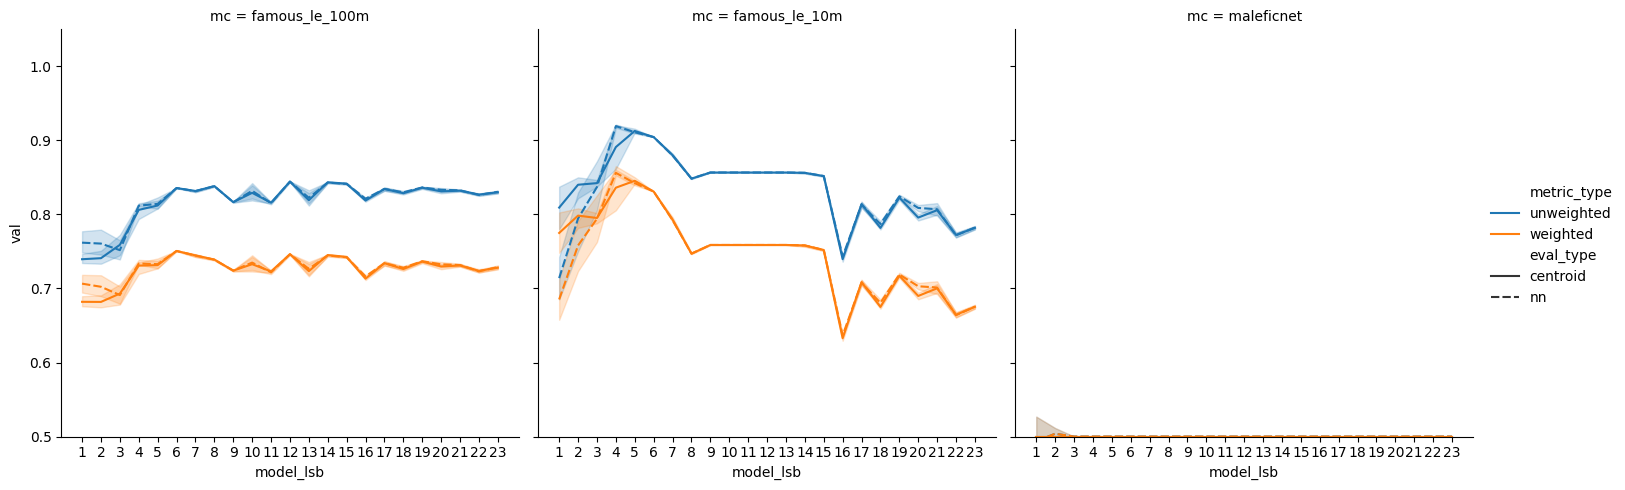

In [16]:
import seaborn as sns

g = sns.relplot(
    data=result_df,
    x='model_lsb',
    y='val',
    col='mc',
    hue='metric_type',
    style='eval_type',
    kind='line'
)

g.set(ylim=(0.5, 1.05))
lsbs = result_df['model_lsb'].unique()
g.set(xticks=lsbs)

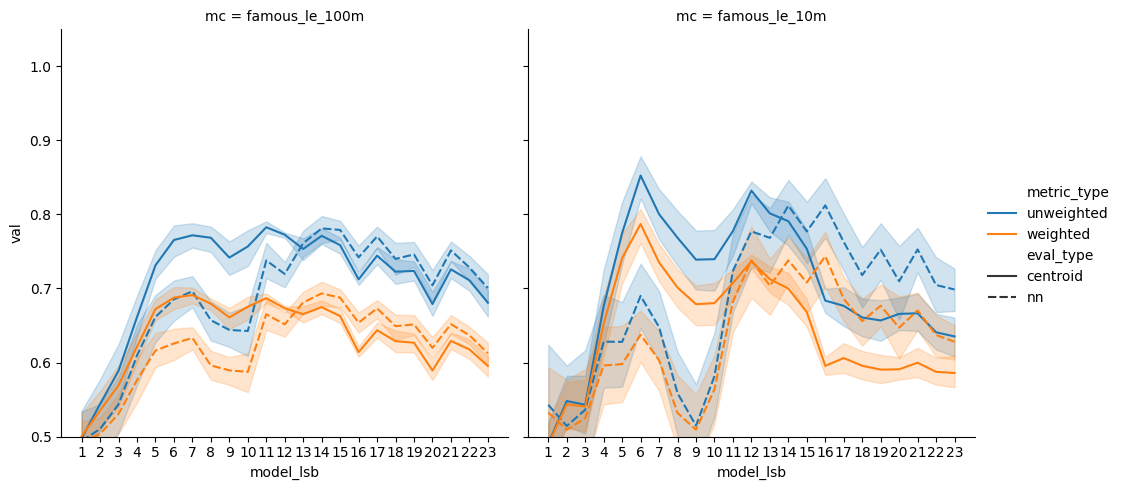

In [132]:
import seaborn as sns

g = sns.relplot(
    data=result_df,
    x='model_lsb',
    y='val',
    col='mc',
    hue='metric_type',
    style='eval_type',
    kind='line'
)

g.set(ylim=(0.5, 1.05))
lsbs = result_df['model_lsb'].unique()
g.set(xticks=lsbs)

# Maleficnet

In [11]:
from typing import Literal, Iterable
import pandas as pd

from model_xray.configs.enums import *

from model_xray.utils.script_utils import get_siamese_results_dataframe

def mask_df_by_df(df: pd.DataFrame, idx_cols: Iterable[str], df_idx: pd.DataFrame) -> pd.DataFrame:
    idx_tuples = df_idx[idx_cols].apply(tuple, axis=1)
    mask = df[idx_cols].apply(tuple, axis=1).isin(idx_tuples)
    return mask

mc_name:Literal['famous_le_10m', 'famous_le_100m']="famous_le_10m"
imtype:ImageType=ImageType.GRAYSCALE_FOURPART
imsize:int=100
mode:Literal['st', 'es', 'ub', 'none']='ub'

model_arch: Literal['osl_siamese_cnn', 'srnet'] = 'osl_siamese_cnn'
embed_payload_type: PayloadType = PayloadType.BINARY_FILE


df = get_siamese_results_dataframe(
    mc_name=mc_name,
    imtype=imtype,
    imsize=imsize,
    mode=mode,
    model_arch=model_arch,
    embed_payload_type=embed_payload_type
)

# df['mc'] = df['mc'].replace(
#     {
#         'maleficnet_benigns': 'maleficnet',
#         'maleficnet_mals': 'maleficnet'
#     }
# )

# df = df.groupby(['run num','mc', 'model_lsb']).apply(calc_metrics, include_groups=False,)
# df.reset_index(inplace=True)

# df.drop(columns=['weighted_metric_centroid', 'weighted_metric_nn'], inplace=True)

idx_cols = ['run num','model_lsb']

acc_threshold = 0.6

maleficnet_benign = (df['mc'] == 'maleficnet_benigns')

maleficnet_benign_over_nn = maleficnet_benign & (df['test_acc_nn'] > acc_threshold)
maleficnet_benign_over_nn_idxs = df[maleficnet_benign_over_nn][idx_cols]

maleficnet_benign_over_centroid = maleficnet_benign & (df['test_acc_centroid'] > acc_threshold)
maleficnet_benign_over_centroid_idxs = df[maleficnet_benign_over_centroid][idx_cols]

maleficnet_mals = (df['mc'] == 'maleficnet_mals')

maleficnet_mals_over_nn = maleficnet_mals & (df['test_acc_nn'] > acc_threshold)
maleficnet_mals_over_nn_idxs = df[maleficnet_mals_over_nn][idx_cols]

maleficnet_mals_over_centroid = maleficnet_mals & (df['test_acc_centroid'] > acc_threshold)
maleficnet_mals_over_centroid_idxs = df[maleficnet_mals_over_centroid][idx_cols]

maleficnet_benign_over_nn_mask = mask_df_by_df(df, idx_cols, maleficnet_benign_over_nn_idxs)
maleficnet_benign_over_centroid_mask = mask_df_by_df(df, idx_cols, maleficnet_benign_over_centroid_idxs)
maleficnet_mals_over_nn_mask = mask_df_by_df(df, idx_cols, maleficnet_mals_over_nn_idxs)
maleficnet_mals_over_centroid_mask = mask_df_by_df(df, idx_cols, maleficnet_mals_over_centroid_idxs)
                                                   
maleficnet_over_nn_mask = maleficnet_benign_over_nn_mask & maleficnet_mals_over_nn_mask
maleficnet_over_centroid_mask = maleficnet_benign_over_centroid_mask & maleficnet_mals_over_centroid_mask

maleficnet_over_mask = maleficnet_over_nn_mask | maleficnet_over_centroid_mask

## NN subset

### maleficnet

In [12]:
nn_subset = df[maleficnet_over_nn_mask].copy()
nn_subset = nn_subset[(nn_subset['mc'] == 'maleficnet_mals') | (nn_subset['mc'] == 'maleficnet_benigns')]

nn_subset.drop(columns=['lsb', 'test_acc_centroid'], inplace=True)
nn_subset = nn_subset.groupby(['run num', 'model_lsb']).mean(numeric_only=True).reset_index().sort_values(by='test_acc_nn', ascending=False)
nn_subset.rename(columns={'test_acc_nn': 'test_acc_maleficnet'}, inplace=True)
nn_subset

,run num,model_lsb,test_acc_maleficnet
2,6,1,0.923077
3,8,2,0.884615
8,42,3,0.794872
9,47,3,0.756410
5,24,3,0.717949
0,2,1,0.717949
6,35,2,0.679487
7,38,1,0.679487
1,5,1,0.641026
4,13,1,0.641026


### Not maleficnet

In [13]:
rest_of_results = df[maleficnet_over_nn_mask].copy()
rest_of_results = rest_of_results[~rest_of_results['mc'].isin(['maleficnet_mals', 'maleficnet_benigns'])]

rest_of_results = rest_of_results[rest_of_results['mc']==mc_name]
rest_of_results.drop(columns=['test_acc_centroid', 'mc'], inplace=True)
rest_of_results

from functools import partial
calc_metrics_only_nn = partial(calc_metrics, centroid=False, nn=True, weighted=True, unweighted=False)

rest_of_results = rest_of_results.groupby(['run num', 'model_lsb']).apply(calc_metrics_only_nn, include_groups=False,).reset_index()
rest_of_results.sort_values(by='weighted_metric_nn', ascending=False)

,run num,model_lsb,weighted_metric_nn
4,13,1,0.809783
7,38,1,0.731522
8,42,3,0.649275
3,8,2,0.623913
9,47,3,0.617391
6,35,2,0.607246
0,2,1,0.603261
5,24,3,0.431522
1,5,1,0.351087
2,6,1,0.342754


### combined

In [14]:
df_combined = nn_subset.merge(rest_of_results, on=['run num', 'model_lsb'], how='outer').sort_values(by='weighted_metric_nn', ascending=False)
df_combined.head(3)

,run num,model_lsb,test_acc_maleficnet,weighted_metric_nn
4,13,1,0.641026,0.809783
7,38,1,0.679487,0.731522
8,42,3,0.794872,0.649275


## centroid subset

### maleficnet

In [15]:
centroid_subset = df[maleficnet_over_centroid_mask].copy()
centroid_subset = centroid_subset[centroid_subset['mc'].isin(['maleficnet_mals', 'maleficnet_benigns'])]

centroid_subset.drop(columns=['lsb', 'test_acc_nn'], inplace=True)
centroid_subset = centroid_subset.groupby(['run num', 'model_lsb']).mean(numeric_only=True).reset_index()

centroid_subset.rename(columns={'test_acc_centroid': 'test_acc_maleficnet'}, inplace=True)
centroid_subset

,run num,model_lsb,test_acc_maleficnet
0,23,2,0.717949
1,31,2,0.807692
2,33,3,0.756410
3,37,2,0.717949
4,42,1,0.756410
5,42,2,0.756410
6,48,1,0.807692
7,48,22,0.756410
8,49,1,0.717949


### not maleficnet

In [16]:
rest_of_results = df[maleficnet_over_centroid_mask].copy()
rest_of_results = rest_of_results[~rest_of_results['mc'].isin(['maleficnet_mals', 'maleficnet_benigns'])]

rest_of_results = rest_of_results[rest_of_results['mc']==mc_name]
rest_of_results.drop(columns=['test_acc_nn', 'mc'], inplace=True)

from functools import partial
calc_metrics_only_centroid = partial(calc_metrics, centroid=True, nn=False, weighted=True, unweighted=False)

rest_of_results = rest_of_results.groupby(['run num', 'model_lsb']).apply(calc_metrics_only_centroid, include_groups=False,).reset_index()
rest_of_results

,run num,model_lsb,weighted_metric_centroid
0,23,2,0.811957
1,31,2,0.812319
2,33,3,0.659783
3,37,2,0.827536
4,42,1,0.374638
5,42,2,0.728623
6,48,1,0.873551
7,48,22,0.744565
8,49,1,0.676087


### combined

In [17]:
df_combined = centroid_subset.merge(rest_of_results, on=['run num', 'model_lsb'], how='outer').sort_values(by='weighted_metric_centroid', ascending=False)
df_combined.head(3)

,run num,model_lsb,test_acc_maleficnet,weighted_metric_centroid
6,48,1,0.807692,0.873551
3,37,2,0.717949,0.827536
1,31,2,0.807692,0.812319


# Both?

In [37]:
both_subset = df[maleficnet_over_nn_mask & maleficnet_over_centroid_mask][((maleficnet_benign) | (maleficnet_mals))].copy()
both_subset

/tmp/ipykernel_2272955/300587096.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  both_subset = df[maleficnet_over_nn_mask & maleficnet_over_centroid_mask][((maleficnet_benign) | (maleficnet_mals))].copy()


,run num,mc,lsb,test_acc_centroid,test_acc_nn,model_lsb


# Whole process

In [6]:
from typing import Literal, Optional, List, Tuple
from matplotlib import pyplot as plt
from notebooks.visualize_utils import get_legacy_supervised_results
import pandas as pd
import seaborn as sns

from model_xray.configs.enums import *

from model_xray.utils.script_utils import get_siamese_results_dataframe

def plot_siamese_results(
    df:Optional[pd.DataFrame]=None,

    mc_name:Literal['famous_le_10m', 'famous_le_100m']="famous_le_10m",
    imtype:ImageType=ImageType.GRAYSCALE_FOURPART,
    imsize:int=256,
    mode:Literal['st', 'es', 'ub', 'none']='ub',
    model_arch: Literal['osl_siamese_cnn', 'srnet'] = 'osl_siamese_cnn',
    embed_payload_type: PayloadType = PayloadType.BINARY_FILE,

    only_model_lsb:bool=False,
    only_model_mc:bool=False,
    include_maleficnet:bool=False,
    include_specific_lsbs:Optional[List[int]]=None,
    include_specific_mcs:Optional[List[str]]=None,
    avg_across_runs:bool=False,

    legend_move_bbox:Optional[Tuple[float, float]]=None,

    add_grid:bool=True,

    plot_model_type: bool=True,

    include_metrics=['weighted',],

    add_baseline:Optional[bool]=None,
):
    if df is None:
        df = concat_siamese_results([
            dict(
                mc_name=mc_name,
                imtype=imtype,
                imsize=imsize,
                mode=mode,
                model_arch=model_arch,
                embed_payload_type=embed_payload_type
            )
        ])
    else:
        mc_name = df['model_mc'].iloc[0]

    if only_model_mc:
        df = df[(df['mc'] == df['model_mc'])]

    if only_model_lsb:
        df = df[(df['model_lsb'] == df['lsb']) | (df['lsb'] == 0)]

    if include_maleficnet:
        df['mc'] = df['mc'].replace(
            {
                'maleficnet_benigns': 'maleficnet',
                'maleficnet_mals': 'maleficnet'
            }
        )

    if include_specific_lsbs is not None:
        df = df[df['lsb'].isin(include_specific_lsbs)]
    
    if include_specific_mcs is not None:
        df = df[df['mc'].isin(include_specific_mcs)]

    metric_calc_idx_cols = [col for col in df.columns if col not in ['test_acc_centroid', 'test_acc_nn', 'lsb']]

    df = df[(df['mc']!='maleficnet_benigns') & (df['mc']!='maleficnet_mals')].groupby(metric_calc_idx_cols).apply(calc_metrics, include_groups=False,)
    df.reset_index(inplace=True)

    if 'weighted' not in include_metrics:
        df.drop(columns=['weighted_metric_centroid', 'weighted_metric_nn'], inplace=True)

    if 'unweighted' not in include_metrics:
        df.drop(columns=['unweighted_metric_centroid', 'unweighted_metric_nn'], inplace=True)

    if avg_across_runs:
        avg_idx_cols = [col for col in df.columns if col not in ['run num',] and 'metric' not in col]
        df = df.groupby(avg_idx_cols).agg('mean').reset_index().drop(columns=['run num'])


    melt_idx_cols = [col for col in df.columns if 'metric' not in col]
    # Melt the DataFrame
    melted_df = pd.melt(df, 
                        id_vars=melt_idx_cols, 
                        var_name='variable', 
                        value_name='val')

    # Extract metric_type and eval_type from the 'variable' column
    melted_df[['metric_type', 'eval_type']] = melted_df['variable'].str.extract(r'(\w+)_(?:\w+)_(\w+)')

    # Drop the original 'variable' column
    melted_df = melted_df.drop('variable', axis=1)

    # Reorder the columns to match the desired output
    df = melted_df

    if len(df['model_arch'].unique()) > 1:
        hue_col = 'model_arch'
    else:
        hue_col = 'eval_type'

    style_col = 'eval_type'

    col_name_map = {
        'model_lsb': 'Model LSB',
        'val': 'Metric',
        'metric_type': 'Metric Type',
        'eval_type': 'Evaluation Type',
        'mc': 'Model Collection',
        'model_arch': 'Model Architecture',
    }

    if only_model_lsb:
        col_name_map['val'] = 'Test Accuracy (Benign + Malicious (X=Model LSB))'

    val_map = {
        'metric_type': {
            'unweighted': 'Unweighted',
            'weighted': 'Weighted',
        },
        'eval_type': {
            'centroid': 'Centroid',
            'nn': '1NN',
        },
        'mc': {
            'famous_le_10m': 'Famous Small CNNs',
            'famous_le_100m': 'Famous Large CNNs',
            'ghrp_stl10': 'SCZ (STL-10)',
        },
        'model_arch': {
            'osl_siamese_cnn': 'OSL CNN',
            'srnet': 'SRNet',
        }
    }

    cols_to_drop = [col for col in df.columns if col not in col_name_map.keys()]
    df.drop(cols_to_drop, axis=1, inplace=True)

    lsbs = df['model_lsb'].unique()
    lsbs.sort()


    if add_baseline is not None and add_baseline and 'ghrp' in mc_name:
        baseline_results = get_legacy_supervised_results(chosen_zoo=mc_name.replace("ghrp_", ''), ).to_list()
        added_rows = []
        for i, lsb in enumerate(lsbs):
            row = {'model_lsb': lsb, 'val': baseline_results[i], 'metric_type': '', 'eval_type': '', 'mc': mc_name, 'model_arch': 'Baseline'}
            added_rows.append(row)
        df = pd.concat([df, pd.DataFrame(added_rows)])

    df.replace(val_map, inplace=True)

    if plot_model_type:
        def create_model_type(s):
            ret = f"{s['model_arch']}"
            eval_type_val = s['eval_type']
            eval_type_str = '' if eval_type_val is None or eval_type_val=='' else f' ({eval_type_val})'

            ret+= eval_type_str

            return ret

        df['model_type'] = df[['model_arch', 'eval_type']].apply(create_model_type, axis=1)
        col_name_map['model_type'] = 'Model Type'

        hue_col = 'model_type'
        style_col = 'model_type'

    
    df.rename(columns=col_name_map, inplace=True)
    

    g = sns.relplot(
        data=df,
        x=col_name_map['model_lsb'],
        y=col_name_map['val'],
        col=col_name_map['mc'],
        hue=col_name_map[hue_col],
        style=col_name_map[style_col],
        kind='line',
        # errorbar='sd',
    )

    g.set(ylim=(0.5, 1.02))
    g.set(xticks=lsbs)

    for ax in g.axes.ravel():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    if add_grid:
        for ax in g.axes.ravel():
            ax.grid()

    if legend_move_bbox:
        sns.move_legend(g, loc='center', bbox_to_anchor=legend_move_bbox, frameon=True)
    
    return g


def concat_siamese_results(
    df_params:List[dict],
):
    dfs = []
    for df_params_curr in df_params:
        df_curr = get_siamese_results_dataframe(**df_params_curr)

        for k,v in df_params_curr.items():
            if k == 'mc_name':
                k='model_mc'
            df_curr[k] = v
        
        dfs.append(df_curr)

    df = pd.concat(dfs)
    return df



# Experiment 1

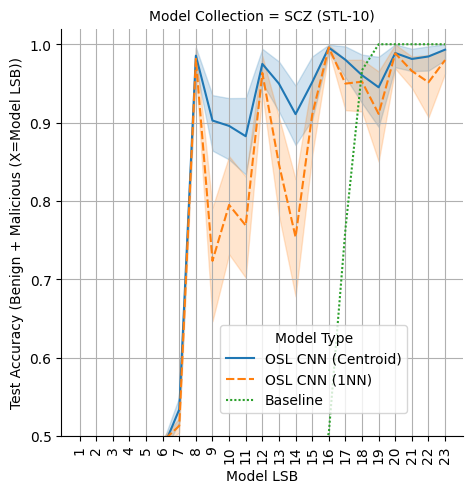

In [7]:
df = concat_siamese_results([
    {
        'mc_name': 'ghrp_stl10',
        'imsize': 100,
        'imtype':ImageType.GRAYSCALE_FOURPART,
        'embed_payload_type': PayloadType.BINARY_FILE,
        'mode': 'ub',
        'model_arch': 'osl_siamese_cnn',
    },
])

g = plot_siamese_results(
    df=df,
    
    avg_across_runs=False,

    only_model_lsb=True,
    only_model_mc=True,
    include_maleficnet=False,

    add_baseline = True,

    legend_move_bbox=(.5, .25),
)

# Experiment 2 (Only Model LSB, ID)

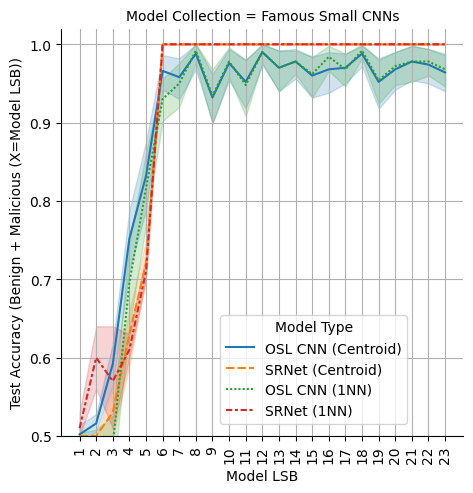

In [8]:
df = concat_siamese_results([
    {
        'mc_name': 'famous_le_10m',
        'imsize': 256,
        'imtype':ImageType.GRAYSCALE_FOURPART,
        'embed_payload_type': PayloadType.BINARY_FILE,
        'mode': 'ub',
        'model_arch': 'srnet',
    },
    {
        'mc_name': 'famous_le_10m',
        'imsize': 100,
        'imtype':ImageType.GRAYSCALE_FOURPART,
        'embed_payload_type': PayloadType.BINARY_FILE,
        'mode': 'ub',
        'model_arch': 'osl_siamese_cnn',
    },

])

g = plot_siamese_results(
    df=df,
    
    avg_across_runs=False,

    only_model_lsb=True,
    only_model_mc=True,
    include_maleficnet=False,

    add_baseline = False,

    legend_move_bbox=(.5, .25),
)

# Experiment 2 (All LSBs, ID)

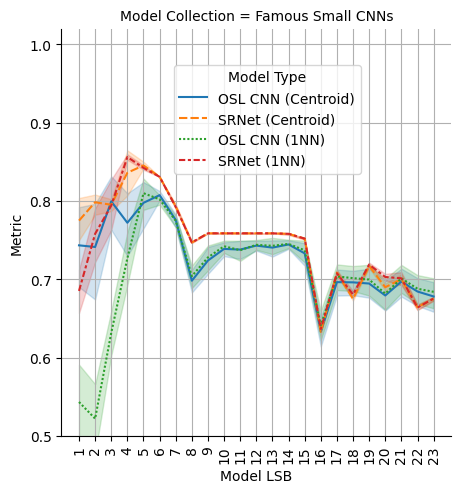

In [9]:
df = concat_siamese_results([
    {
        'mc_name': 'famous_le_10m',
        'imsize': 256,
        'imtype':ImageType.GRAYSCALE_FOURPART,
        'embed_payload_type': PayloadType.BINARY_FILE,
        'mode': 'ub',
        'model_arch': 'srnet',
    },
    {
        'mc_name': 'famous_le_10m',
        'imsize': 100,
        'imtype':ImageType.GRAYSCALE_FOURPART,
        'embed_payload_type': PayloadType.BINARY_FILE,
        'mode': 'ub',
        'model_arch': 'osl_siamese_cnn',
    },

])

g = plot_siamese_results(
    df=df,
    
    avg_across_runs=False,

    only_model_lsb=False,
    only_model_mc=True,
    include_maleficnet=False,

    add_baseline = False,

    legend_move_bbox=(.45, .75),
)

# Experiment 2 (Only Model LSB, OOD)

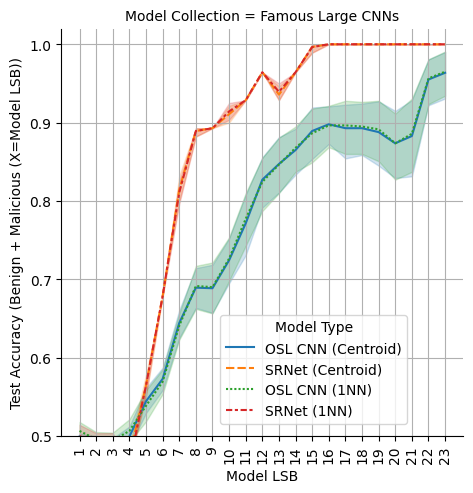

In [71]:
df = concat_siamese_results([
    {
        'mc_name': 'famous_le_10m',
        'imsize': 256,
        'imtype':ImageType.GRAYSCALE_FOURPART,
        'embed_payload_type': PayloadType.BINARY_FILE,
        'mode': 'ub',
        'model_arch': 'srnet',
    },
    {
        'mc_name': 'famous_le_10m',
        'imsize': 100,
        'imtype':ImageType.GRAYSCALE_FOURPART,
        'embed_payload_type': PayloadType.BINARY_FILE,
        'mode': 'ub',
        'model_arch': 'osl_siamese_cnn',
    },

])

g = plot_siamese_results(
    df=df,
    
    avg_across_runs=False,

    only_model_lsb=True,
    only_model_mc=False,

    include_specific_mcs=['famous_le_100m'],

    include_maleficnet=False,

    add_baseline = False,

    legend_move_bbox=(.5, .25),
)

# Experiment 2 (All LSBs, OOD)

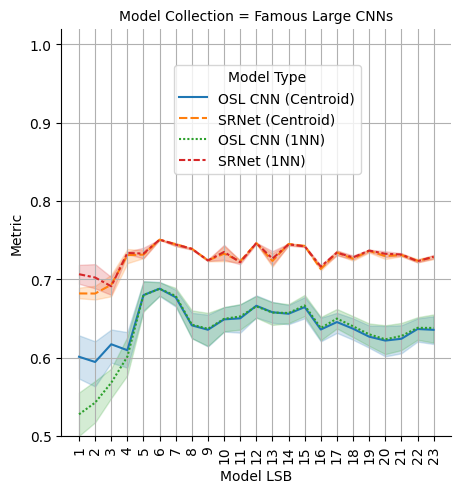

In [73]:
df = concat_siamese_results([
    {
        'mc_name': 'famous_le_10m',
        'imsize': 256,
        'imtype':ImageType.GRAYSCALE_FOURPART,
        'embed_payload_type': PayloadType.BINARY_FILE,
        'mode': 'ub',
        'model_arch': 'srnet',
    },
    {
        'mc_name': 'famous_le_10m',
        'imsize': 100,
        'imtype':ImageType.GRAYSCALE_FOURPART,
        'embed_payload_type': PayloadType.BINARY_FILE,
        'mode': 'ub',
        'model_arch': 'osl_siamese_cnn',
    },

])

g = plot_siamese_results(
    df=df,
    
    avg_across_runs=False,

    only_model_lsb=False,
    only_model_mc=False,

    include_specific_mcs=['famous_le_100m'],

    include_maleficnet=False,

    add_baseline = False,

    legend_move_bbox=(.45, .75),
)